In [1]:
# import packages
import glob
from pathlib import Path
import scipy.stats
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pathos.threading import ThreadPool as Pool
from scipy.stats import gaussian_kde
import xarray as xr
from matplotlib import cm
import matplotlib

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
work_dir=Path("/scratch/fransjevanoors/global_sr")
# work_dir=Path("/mnt/u/LSM root zone/global_sr")

In [7]:
# RUN SR CALCULATION 
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# check which catchments are missing
c_list=[]
# for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/*.csv'):
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    c_list.append(f)
dif = list(set(catch_list) - set(c_list))

# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]
# f_array = ['0.9ia']
f_array = ['iwu2']
catch_id_list = dif
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
f_list = f_array * len(catch_id_list)

In [72]:
def sdmaxmin_noirri(catch_id,sd_dir):
    # check if sd exists for catchment id
    if(os.path.exists(f'{sd_dir}/no_irri/sd/{catch_id}.csv')==True):  

        # read storage deficit table
        sd_table = pd.read_csv(f'{sd_dir}/no_irri/sd/{catch_id}.csv',index_col=0)
        sd_table.index = pd.to_datetime(sd_table.index)

        # get sd, start and end year and date from sd_table
        if 'sd2' in sd_table.columns:
            Sd = sd_table.sd2
        else:
            Sd = sd_table.Sd

        year_start = sd_table.index[0].year
        year_end = sd_table.index[-1].year
        date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
        date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
        if(date_end=='2-29'):
            date_end='2-28'

    if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
        # inverse of sd
        Sd = Sd*-1

        # count years
        total_years = year_end - year_start
        years = range(year_start,year_end+1,1)

        # calculate annual max Sd - without iterations for hydro years
        # CHECK THIS PROCEDURE AGAIN FRANSJE
        Sd_max=[]
        Sd_maxmin = []
        if (str(date_start)=='1-1'):
            for i in range(0,total_years+1,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
        else:
            for i in range(0,total_years,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
    return Sd_maxmin

In [71]:
def sdmaxmin_irri(catch_id,f,sd_dir):
    # check if sd exists for catchment id
    if(os.path.exists(f'{sd_dir}/irri/f{f}/sd/{catch_id}_f{f}.csv')==True):  

        # read storage deficit table
        sd_table = pd.read_csv(f'{sd_dir}/irri/f{f}/sd/{catch_id}_f{f}.csv',index_col=0)
        sd_table.index = pd.to_datetime(sd_table.index)

        # get sd, start and end year and date from sd_table
        if 'sd2' in sd_table.columns:
            Sd = sd_table.sd2
        else:
            Sd = sd_table.Sd

        year_start = sd_table.index[0].year
        year_end = sd_table.index[-1].year
        date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
        date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
        if(date_end=='2-29'):
            date_end='2-28'

    if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
        # inverse of sd
        Sd = Sd*-1

        # count years
        total_years = year_end - year_start
        years = range(year_start,year_end+1,1)

        # calculate annual max Sd - without iterations for hydro years
        # CHECK THIS PROCEDURE AGAIN FRANSJE
        Sd_max=[]
        Sd_maxmin = []
        if (str(date_start)=='1-1'):
            for i in range(0,total_years+1,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
        else:
            for i in range(0,total_years,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
    return Sd_maxmin

    #         # calculate sr for different return periods using (4)
    #         sr_T = sr_return_periods_minmax_rzyear(rp_array, Sd, year_start, year_end, date_start, date_end)

    #         # store dataframe with catchment sr values
    #         sr_df = pd.DataFrame(index=[catch_id], columns=rp_array)
    #         sr_df.loc[catch_id]=sr_T

    #         sr_df.to_csv(f'{sd_dir}/irri/f{f}/sr/{catch_id}_f{f}.csv')

In [60]:
def gumbel(Sd_maxmin):
    m = len(Sd_maxmin)
    df = pd.DataFrame(index=np.arange(1,len(Sd_maxmin)+1,1),columns=['sd','i','p','q','y'])
    df['sd'] = Sd_maxmin
    df = df.sort_values('sd',ascending=False)
    df['i'] = np.arange(1,len(Sd_maxmin)+1,1)
    df['p'] = df['i']/(m+1)
    df['q'] = 1-df['p']
    df['y'] = -np.log(-np.log(df['q']))

    # exercise: compute Gumbel parameters (name them sigma and mu)
    s_R = df['sd'].std()
    s_y = df['y'].std()
    y_gem = df['y'].mean()
    R_max_gem = df['sd'].mean()
    sigma = s_R / s_y
    mu = R_max_gem - s_R * (y_gem / s_y)

    # Now we can construct the Gumbel fit and plot the Gumbel line
    dummy_y = np.arange(-2,6.01,0.2)
    R_Gumbel = sigma * dummy_y + mu

    # Here we define the return periods and we inspect the difference between the two return periods
    T_interest = np.asarray([1,2,3,5,10,20,30,40,50,60,70,80])
    T_a_interest = 1 / (1-np.exp(-1/T_interest))

    # real return period for the observed annual maxima
    T_a = 1 / df.p
    df.loc[:,'T_a'] = T_a
    T = -1 / np.log(1 - 1/df['T_a'].values)
    df.loc[:,'T'] = T

    # exercise, Gumbel estimate for return period array T_interest
    gumbel_estimate = sigma * (-np.log(1/T_interest)) + mu
    
    return(df,T,gumbel_estimate)

In [81]:
def gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2):
    # create the figure
    fig, ax = plt.subplots(figsize=(9,7))
    ax.plot(T1, df1['sd'].values,'xg', markersize=7, label='Observed Annual Maxima 1')
    ax.plot(T_interest, gumbel_estimate1, ':og', label = 'Gumbel Estimate 1')
    ax.plot(T2, df2['sd'].values,'xm', markersize=7, label='Observed Annual Maxima 2')
    ax.plot(T_interest, gumbel_estimate2, ':om', label = 'Gumbel Estimate2 ')
    ax.vlines(2,0,300)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Sd (mm)')
    ax.set_xscale('log')
    ax.legend(loc='best',framealpha=0.5)
    ax.grid(True)

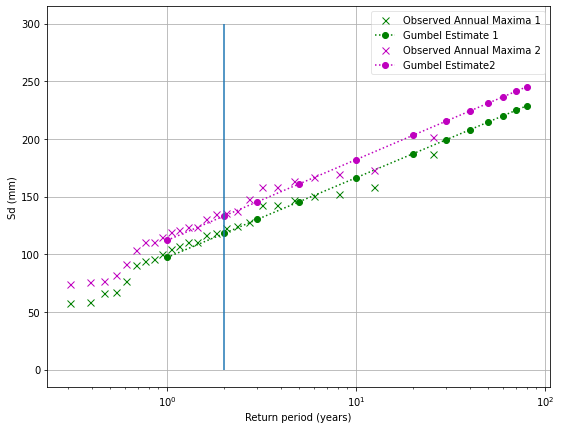

In [82]:
c0 = 'br_0002791'
c1 = 'us_0005570'
c5 = 'es_0000301'
c10 = 'in_0000134'

catch_id = c5
f='iwu2'
Sd_maxmin1 = sdmaxmin(catch_id,f,sd_dir)
Sd_maxmin2 = sdmaxmin_noirri(catch_id,sd_dir)

df1,T1,gumbel_estimate1 = gumbel(Sd_maxmin1)
df2,T2,gumbel_estimate2 = gumbel(Sd_maxmin2)

gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2)

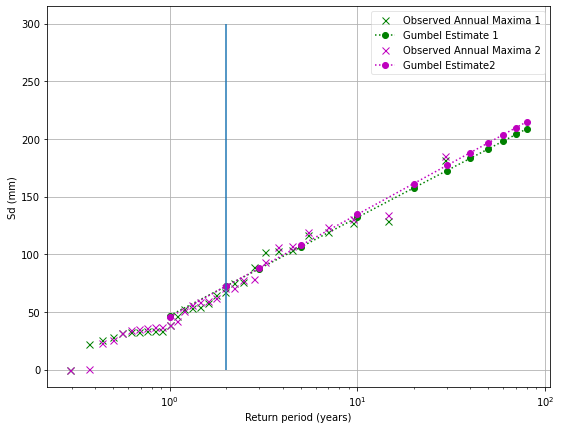

In [86]:
#catch list with catchments with Sr IWU > Sr NI
c_list = ['us_0004753', 'es_0000786', 'za_0000238', 'ca_0006320', 'se_0000041',
       'at_0000137', 'ca_0003756', 'br_0002437', 'fr_0001306', 'us_0005876',
       'mx_0000025', 'fr_0000730', 'ca_0006226', 'es_0000190', 'ch_0000044',
       'ca_0000774', 'ru_0000296', 'us_0006397', 'es_0000977', 'br_0001432',
       'na_0000040', 'ca_0002172', 'br_0001238', 'es_0000232', 'cz_0000030',
       'es_0001066', 'es_0000590', 'us_0005866', 'es_0001063', 'us_0005535',
       'th_0000180']
catch_id = c_list[15]
f='iwu2'
Sd_maxmin1 = sdmaxmin(catch_id,f,sd_dir)
Sd_maxmin2 = sdmaxmin_noirri(catch_id,sd_dir)

df1,T1,gumbel_estimate1 = gumbel(Sd_maxmin1)
df2,T2,gumbel_estimate2 = gumbel(Sd_maxmin2)

gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2)

In [45]:
def gumbel_r_mom(x):
    """
    gumbel extreme value analysis
    x:        list of max sd values per year
    returns:  loc and scale of gumbel distribution

    """
    scale = np.sqrt(6)/np.pi * np.std(x)
    loc = np.mean(x) - np.euler_gamma*scale
    return loc, scale  

In [46]:
gumbel_r_mom(Sd_maxmin)

(56.20993812483148, 45.09327901521682)

In [ ]:
def gumbel_r_mom(x):
    """
    gumbel extreme value analysis
    x:        list of max sd values per year
    returns:  loc and scale of gumbel distribution

    """
    scale = np.sqrt(6)/np.pi * np.std(x)
    loc = np.mean(x) - np.euler_gamma*scale
    return loc, scale    

# calculate gumbel parameters
# loc1, scale1 = gumbel_r_mom(Sd_maxmin_rz_year)
loc1, scale1 = gumbel_r_mom(Sd_maxmin)

# find Sd value corresponding with return period
Sd_T = []
for i in np.arange(0,len(rp_array),1):
    p = 1-(1/rp_array[i])
    y = -np.log(-np.log(p))
    x = scale1 * y + loc1
    Sd_T.append(x)
         

In [ ]:
def sr_return_periods_minmax_rzyear(rp_array,Sd,year_start,year_end,date_start,date_end):
    """
    calculate sr for different return periods - min max root zone year approach from Stijn??
    
    rp_array:   int, array, list of return periods
    sd:         pandas df, storage deficits
    year_start: str, start year
    year_end:   str, end year
    date_start: str, month-day start
    date_end:   str, month-day end
    
    returns:
    Sd_T:       list of storage deficit for return periods in rp_array
    
    """

    # inverse of sd
    Sd = Sd*-1
    
    # count years
    total_years = year_end - year_start
    years = range(year_start,year_end+1,1)

    # calculate annual max Sd - without iterations for hydro years
    # CHECK THIS PROCEDURE AGAIN FRANSJE
    Sd_max=[]
    Sd_maxmin = []
    if (str(date_start)=='1-1'):
        for i in range(0,total_years+1,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
            Sd_max.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
    else:
        for i in range(0,total_years,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
            Sd_max.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year

    # define root zone year
    sd_max_month = Sd.groupby(pd.Grouper(freq='M')).max() #calculate maximum sd per month
    sd_max_month_sum =  sd_max_month.groupby([sd_max_month.index.month]).sum() #sum max sd per month for full timeseries per month
    start_rz_year = sd_max_month_sum.idxmin() #define month where rz year starts
    date_start_rz_year = str(start_rz_year)+'-1'        
    if(start_rz_year==1):
        start_rz_year=13
    day_end_rz_year = calendar.monthrange(2010,start_rz_year-1)[1] #find last day of end month rz year
    date_end_rz_year = str(start_rz_year-1)+'-'+str(day_end_rz_year)

    # calculate annual max Sd - without iterations for rootzone years -> CHECK THIS APPROACH
    Sd_max_rz_year = []
    Sd_maxmin_rz_year = []
    if (str(date_start_rz_year)=='1-1'):
        for i in range(0,total_years+1,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i])+'-'+str(date_end_rz_year)])
            Sd_max_rz_year.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start_rz_year), str(years[i])+'-'+str(date_end_rz_year))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i])+'-'+str(date_end_rz_year)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):sd_max_ix] #timeseries from start rzyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin_rz_year.append(sd_max_i-min_value) #append max-min sd per year
    else:
        for i in range(0,total_years,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i+1])+'-'+str(date_end_rz_year)])
            Sd_max_rz_year.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start_rz_year), str(years[i+1])+'-'+str(date_end_rz_year))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i+1])+'-'+str(date_end_rz_year)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):sd_max_ix] #timeseries from start rzyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin_rz_year.append(sd_max_i-min_value) #append max-min sd per year        
        
    # gumbel function
    def gumbel_r_mom(x):
        """
        gumbel extreme value analysis
        x:        list of max sd values per year
        returns:  loc and scale of gumbel distribution
        
        """
        scale = np.sqrt(6)/np.pi * np.std(x)
        loc = np.mean(x) - np.euler_gamma*scale
        return loc, scale    

    # calculate gumbel parameters
    # loc1, scale1 = gumbel_r_mom(Sd_maxmin_rz_year)
    loc1, scale1 = gumbel_r_mom(Sd_maxmin)

    # find Sd value corresponding with return period
    Sd_T = []
    for i in np.arange(0,len(rp_array),1):
        p = 1-(1/rp_array[i])
        y = -np.log(-np.log(p))
        x = scale1 * y + loc1
        Sd_T.append(x)
         
    return(Sd_T)  